# Set up

In [82]:
# install.packages("corrplot")
# install.packages("car")
# install.packages("stargazer")
# install.packages("sandwich")
# install.packages("robustbase")

library(car)
library(corrplot)
library(stargazer)
library(sandwich)
library(lmtest)
library(robustbase)

# Introduction

The great state of North Carolina and its 100 counties make for a diverse place, with both urban and rural, richer and poorer areas. Today, the state capital of Raleigh is a thriving research-based region, while the city of Charlotte is the 2nd largest Banking center in the US after New York. However, there are obvious concerns related to violence and crime statistics. With the upcoming elections in most of the 13 congressional districts of the state, our agency has been hired to provide a detailed research on crime rates in the state and how best to provide an actionable set of policy recommendations -- so that the candidate could lay those out to the election going public and hopefully also sway indepenedents in their favor.  

# Research question

Our project aims to determine whether wage increases in one industry are able to reduce crime. It is commonly known that crime tends to correlate with factors such as higher population density and urban areas; however, there has been less research on the effect of wages on an area's crime rate.

Nonetheless, we accept that while government policies are able to affect other industries (e.g., through the minimum wage), if most of the employees in an industry already make more that the minimum wage, that effect is significantly dampened. However, government wages can be potentially affected by policy much more directly.

Thus given this potentially actionable policy recommendation that might be obtained from our research, **we seek to determine whether wage increases in government jobs are able to reduce crime.**

Based on the results of this analysis, we aim to recommend whether our political compaign should advocate for higher government wages as well as potentially continue research in wages within other industries. Note that whether or not economic prosperity has an effect on crime, it continues to be a worthy goal with many potential positive effects in other parts of our constituents lives; additional research will be required to determine the effects on other aspects of quality-of-life.

# Methodology and EDA

We use data from C. Cornwell and W. Trumball (1994), “Estimating the Economic Model of Crime with Panel Data,” Review of Economics and Statistics 76, 360-366.

We start by reading in the data and checking then number of blank cells. We see that almost all of the columns have 6 nulls which are caused by reading in empty rows at the bottom of the dataframe. We remove these data points. 

In [52]:
data <- read.table("crime_v2.csv", header=TRUE, sep=",")
colSums(is.na(data))
tail(data, 10)
data <- na.omit(data, cols="county")  # Remove empty rows read into bottom of table

county     year   crmrte   prbarr  prbconv  prbpris   avgsen    polpc 
       6        6        6        6        0        6        6        6 
 density    taxpc     west  central    urban pctmin80     wcon     wtuc 
       6        6        6        6        6        6        6        6 
    wtrd     wfir     wser     wmfg     wfed     wsta     wloc      mix 
       6        6        6        6        6        6        6        6 
 pctymle 
       6

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,...,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
88,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,...,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.11050157,0.07819394
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,...,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.11050157,0.07819394
90,195,87,0.0313973,0.201397,1.670519948,0.470588,13.02,0.00445923,1.7459893,53.66693,...,377.9356,246.0614,411.4330,296.8684,392.27,480.79,303.11,337.28,0.15612382,0.07945071
91,197,87,0.0141928,0.207595,1.182929993,0.360825,12.23,0.00118573,0.8898810,25.95258,...,341.8803,182.8020,348.1432,212.8205,322.92,391.72,385.65,306.85,0.06756757,0.07419893
92,NA,NA,NA,NA,,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
93,NA,NA,NA,NA,,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
94,NA,NA,NA,NA,,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
95,NA,NA,NA,NA,,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
96,NA,NA,NA,NA,,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
97,NA,NA,NA,NA,`,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Next, we take a look at the datatypes for each of the columns and notice that one of the colums `prbconv`, probability of conviction was actually loaded as  a factor.  We convert this into a numeric instead.

In [53]:
sapply(data, class)
data$prbconv <- as.numeric(as.character(data$prbconv))  # Convert factor column to numeric

county      year    crmrte    prbarr   prbconv   prbpris    avgsen     polpc 
"integer" "integer" "numeric" "numeric"  "factor" "numeric" "numeric" "numeric" 
  density     taxpc      west   central     urban  pctmin80      wcon      wtuc 
"numeric" "numeric" "integer" "integer" "integer" "numeric" "numeric" "numeric" 
     wtrd      wfir      wser      wmfg      wfed      wsta      wloc       mix 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
  pctymle 
"numeric"

Taking a look at the summary of our data, we see that
1. `year` is a constant and can be removed as the min, median, mean, max, etc. are all the same
2. `prbarr`, probability of arrest, and `prbconv`, probability of conviction, have maximum values that are larger than 100%. Probabilities shouldn't have values over 100%. As we do not know if these data points were miss-entered and were supposed to be very low (e.g., 1.09 should have been 0.109) or were supposed to simply be at 100% (very high), it is safer for us just to remove these data points.
3. `wser`, wages in the services industry, seems to have a maximum significantly larger than the median, mean and the quartiles, which seems to indicate that there is a significant outlier. If we decide to use this data point in our models, we'll have to take a closer look to determine whether this point should be retained or removed.

In [54]:
summary(data)
data = subset(data, select=-c(year))
data = data[data$prbarr <= 1.0 & data$prbconv <= 1.0,]

     county           year        crmrte             prbarr       
 Min.   :  1.0   Min.   :87   Min.   :0.005533   Min.   :0.09277  
 1st Qu.: 52.0   1st Qu.:87   1st Qu.:0.020927   1st Qu.:0.20568  
 Median :105.0   Median :87   Median :0.029986   Median :0.27095  
 Mean   :101.6   Mean   :87   Mean   :0.033400   Mean   :0.29492  
 3rd Qu.:152.0   3rd Qu.:87   3rd Qu.:0.039642   3rd Qu.:0.34438  
 Max.   :197.0   Max.   :87   Max.   :0.098966   Max.   :1.09091  
    prbconv           prbpris           avgsen           polpc          
 Min.   :0.06838   Min.   :0.1500   Min.   : 5.380   Min.   :0.0007459  
 1st Qu.:0.34541   1st Qu.:0.3648   1st Qu.: 7.340   1st Qu.:0.0012308  
 Median :0.45283   Median :0.4234   Median : 9.100   Median :0.0014853  
 Mean   :0.55128   Mean   :0.4108   Mean   : 9.647   Mean   :0.0017022  
 3rd Qu.:0.58886   3rd Qu.:0.4568   3rd Qu.:11.420   3rd Qu.:0.0018768  
 Max.   :2.12121   Max.   :0.6000   Max.   :20.700   Max.   :0.0090543  
    density         

Lastly, as part of our normal data cleaning process, we check for duplicates and notice that there is one. et's remove this duplicate

In [55]:
sum(duplicated(data))
data = data[!duplicated(data), ] 

[1] 1

Because we're interested in the economic determinants of crime, we have decided to define the average number of crimes per person `crmrte` as our endogenous variable that we will regress.

Next, we look at the correlations between our variables (below) to look for potentially informative features as well as multi-collinearity. Even though there are a number of variables that are correlated with each other (e.g., all of the wage variables), we do not see any perfect multi-collinearity in the correlation matrix.

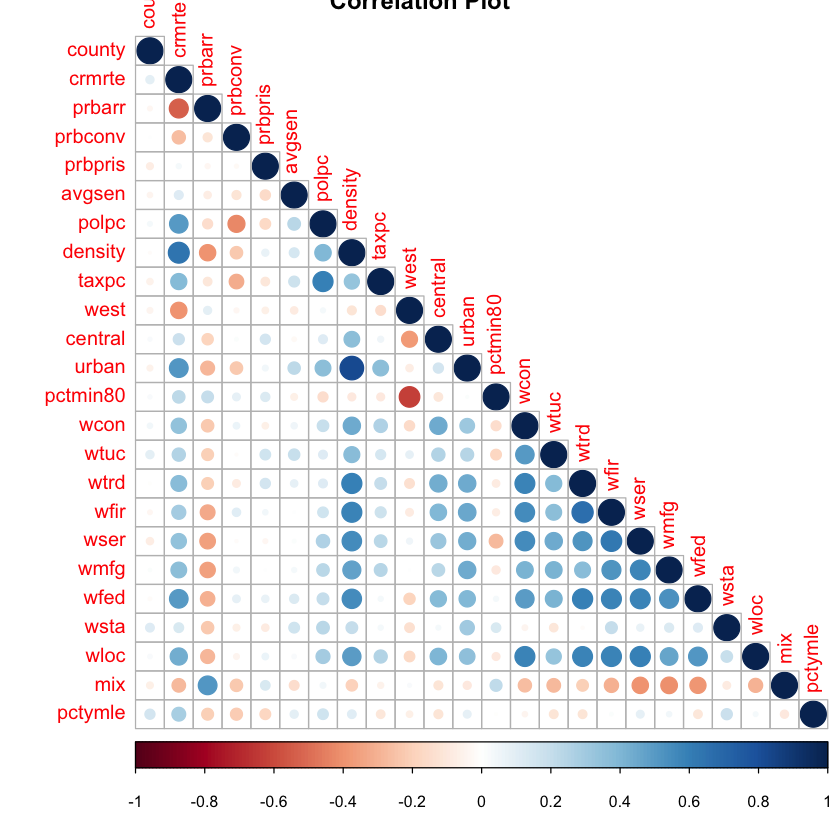

In [64]:
correlations <- cor(data)
corrplot(correlations, type="lower", method='circle', main="Correlation Plot")

We do see that the following variables are most correlated with crime rate: 
* wage related variables: `wcon`, `wtuc`, `wtrd`, `wfir`, `wser`, `wmfg`, `wfed`, `wsta`, `wloc`
* population density variables
* police presence and conviction variables

--------------------

Our first model will only look at crime rate regressed on the wage in government jobs, `wfed`, `wsta`, `wloc`. However, as this does not take into account of important latent variables that also have a strong impact on crime (e.g., population density, police presence, tax rate), we build a second model with both the wage variable and key co-variates included. This way, we are able to isolate the effect of wages on crime without the interference of some of the key latent variables.

Lastly, we create a larger model with all of the main variables included to further isolate the effect of wages on crime. After each model, we will discuss the potential effects of omitted latent variables that we either have not yet included into the model or do not have data for.

Note that for our non-wage-related variables, we transform them (e.g., log, sqrt) as necessary to optimize the strength of their relationship with crime rate. Even though, it reduces the explainability of the non-wage-related variables, our key focus is on the effect of wages on crime anyway. By controlling as much as possible for the effect of other variables (by optimally transforming them to have a strong linear relationship with crime rate), we can focus more on the incremental impact of wages on crime. In other words, we are controlling for otherwise omitted latent relationships (e.g., non-linear) from other variables that may be affecting our wage variables.

We will need to take a closer look at our wage and crime rate variables in the section below before determining whether we want to transform them (e.g., potentially for a more robust model) or keep them untransformed (e.g., potentially for easier interpretability).

--------------------

Note that we've chosen to exclude the following columns:
* `urban`
* `county`
* `mix`

We exclude `urban` because it is defined as basically a calculated variable from `density` (based on the definition given in Cornwell & Trumball). We exclude county because it is an identifier column and not a characteristic. And lastly, we exclude `mix` because it is a descriptor of types of crime and thus not a possible causal variable of crime itself.

# Model 1 

We first take a look at the distribution of each of our variables. They all look roughly normal although there is some right skew in `crmrte`. `wfed`, `wsta`, and `wloc` are all roughly normally distributed.

Because we have a large sample, the right skew in `crmrte` should not be an issue due to the CLT. Nonetheless, we take a look at the log transformed version of `crmrte` and see that it is significantly more normal. Because we are able to keep our interpretability even with a log transform, we decide to do so.

We see that the log transformed wage variables have a similar distribution to what they had prior to the transformation. Because they do not seem to become more skewed and because a log-transform of wages helps for interpretability (e.g., \\$300 increase may be small when you're earning \\$5000 but large when you're earning \\$100), we decide to log-transform the three wage variables as well. When we log-transform, we're looking at the change in percentage rather than change in absolute number, which makes sense for wages (e.g., 10% increase in wages).

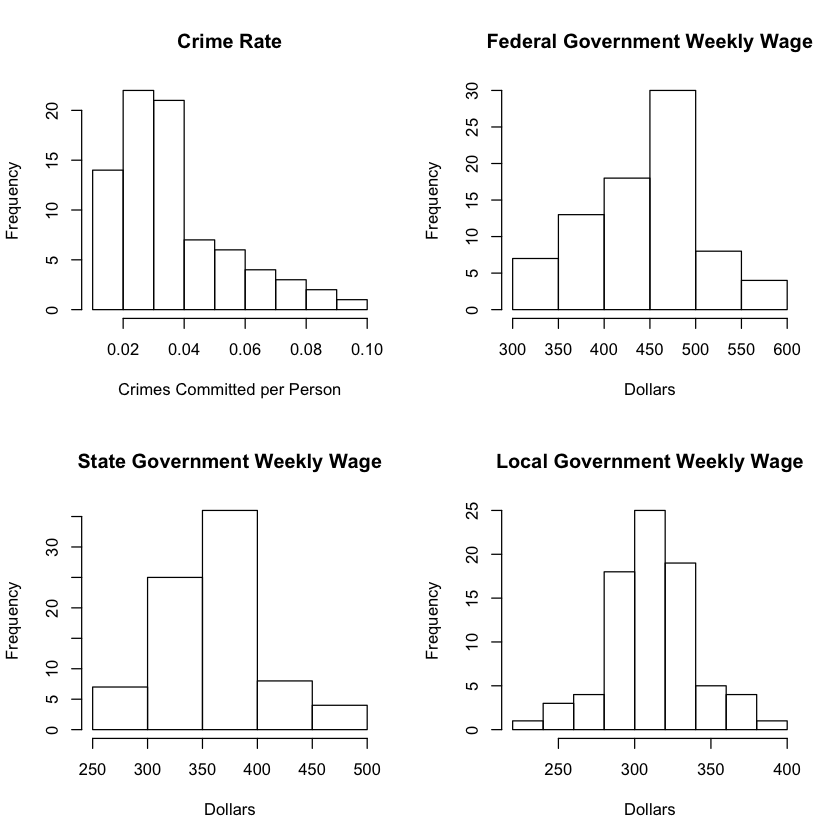

In [57]:
par(mfrow=c(2,2))
hist(data$crmrte, main = "Crime Rate", xlab = "Crimes Committed per Person")
hist(data$wfed, main = "Federal Government Weekly Wage", xlab = "Dollars")
hist(data$wsta, main = "State Government Weekly Wage", xlab = "Dollars")
hist(data$wloc, main = "Local Government Weekly Wage", xlab = "Dollars")

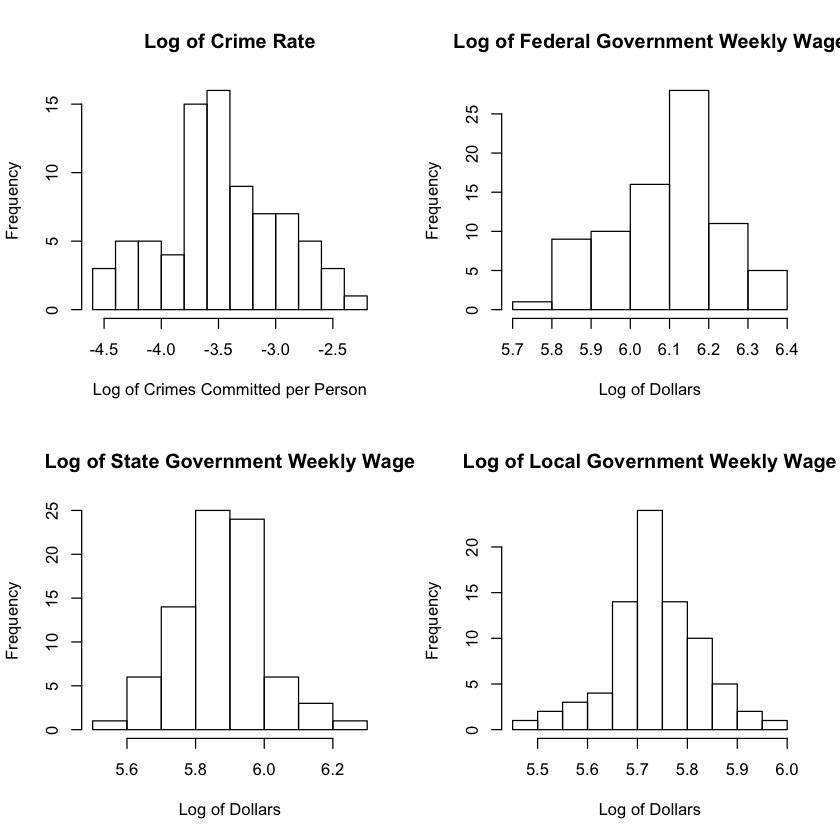

In [58]:
par(mfrow=c(2,2))
hist(log(data$crmrte), main = "Log of Crime Rate", xlab = "Log of Crimes Committed per Person")
hist(log(data$wfed), main = "Log of Federal Government Weekly Wage", xlab = "Log of Dollars")
hist(log(data$wsta), main = "Log of State Government Weekly Wage", xlab = "Log of Dollars")
hist(log(data$wloc), main = "Log of Local Government Weekly Wage", xlab = "Log of Dollars")
data$crmrte = log(data$crmrte)
data$wfed = log(data$wfed)
data$wsta = log(data$wsta)
data$wloc = log(data$wloc)

Our first model regresses crime rate on the average weekly wage of different government jobs. We see that these variables are able to explain about 27% of the variability in the crime rate (based on adjusted R2).

Next, we'll want to confirm the MLR assumptions before continuing in our analysis and interpretation.

In [59]:
model = lm(crmrte ~ wfed + wsta + wloc, data=data)
model_summary = summary(model)
paste('Adjusted R-Squared is', model_summary$adj.r.squared)
model_summary

[1] "Adjusted R-Squared is 0.27581260132406"


Call:
lm(formula = crmrte ~ wfed + wsta + wloc, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1089 -0.2597 -0.0354  0.2450  1.2293 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.5176     3.6298  -5.653 2.63e-07 ***
wfed          1.3981     0.4056   3.447 0.000928 ***
wsta          0.2121     0.4205   0.504 0.615426    
wloc          1.2711     0.6329   2.008 0.048159 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4321 on 76 degrees of freedom
Multiple R-squared:  0.3033,	Adjusted R-squared:  0.2758 
F-statistic: 11.03 on 3 and 76 DF,  p-value: 4.318e-06


### Analysis of CLM assumptions:
#### Following are the CLM assumptions: 
1. Linear population model
2. Random Sampling
3. No perfect multicollinearity
4. Zero-conditional mean
5. Homoskedasticity
6. Normality of Errors


#### Following first three assumptions should hold for all subsequent linear models:
1. **Linear population model:** we have created a linear population model using lm() and hence the condition of linearity of coefficients is satisfied

2. **Random Sampling:** we are entirely certain whether or not this data is randomly sampled. Even though we have 90 out of 100 counties represented in our dataset, the summary statistics for each of the counties may or may not have been randomly sampled. For example, for wages, it is unclear whether the researchers had sampled wages from the richest areas in a county or whether wages was truly randomly sampled. Even though we cannot confirm that the data is i.i.d., for the remainder of the model, we will place our faith in Cornwell and Trumbull and assume that the data is randomly sampled.

3. **No perfect multicollinearity:** we have created correlation tables below and do not find any values of 1 between different variables, hence the no perfect multicollinearity assumption holds too.

In [71]:
cor(data[c('wfed', 'wsta', 'wloc')])

,wfed,wsta,wloc
wfed,1.000000,0.1167490,0.5183780
wsta,0.116749,1.0000000,0.1970533
wloc,0.518378,0.1970533,1.0000000


#### Following tests applied for zero-conditional mean and homoskedasticity error assumptions:
4. **Zero-conditional mean**: In the Residuals vs Fitted plot, we see that the red smoothing line is almost flat, indicating that the conditional mean is roughly zero

5. **Homoskedasticity**: In the Scale-Location plot we see that the smoothing line has a bit of a U-bend shape, which indicates that there may be a bit of heteroskedasticity. The Breusch-Pagan test indicates a p-value < 0.05, leading us to reject the null hypothesis of homoskedasticity. Thus, we will use the heteroskedastic robust errors.


	studentized Breusch-Pagan test

data:  model
BP = 17.973, df = 3, p-value = 0.0004455


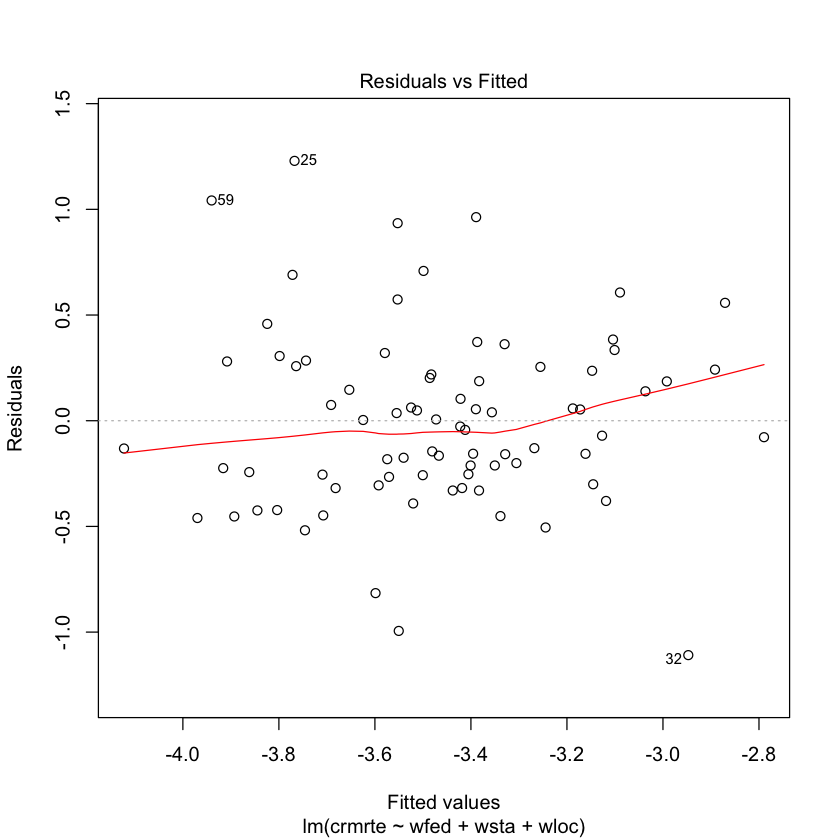

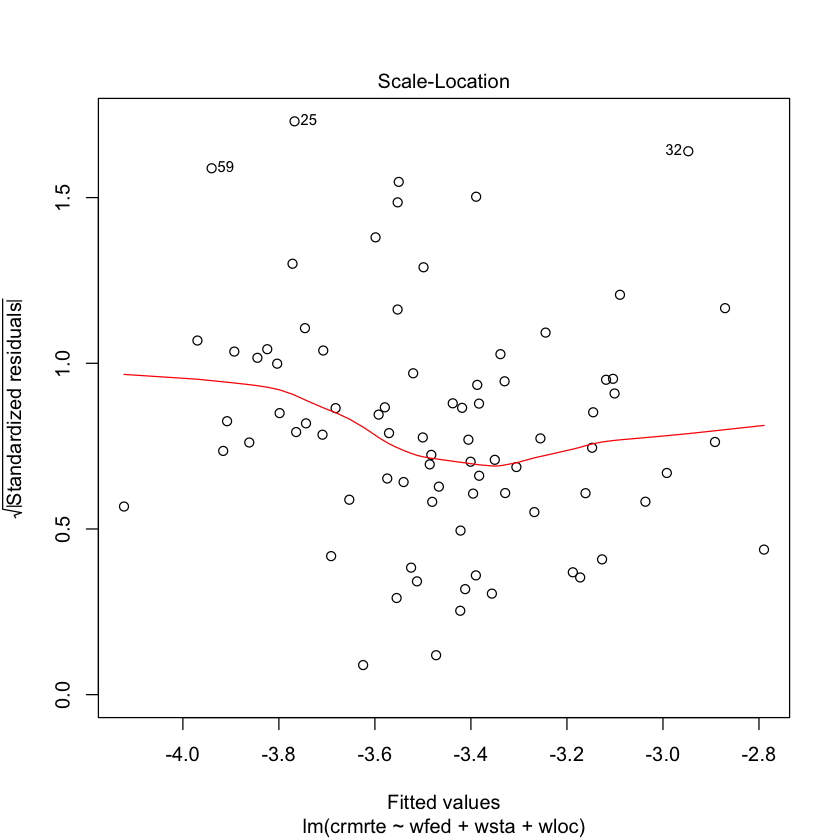

In [76]:
plot(model, which = 1)
bptest(model)
plot(model, which = 3)

6. **Normality of Errors:** Our QQ plot shows evidence of some non-normality, but is overall relatively normal as most of the points show up on the diagonal line.

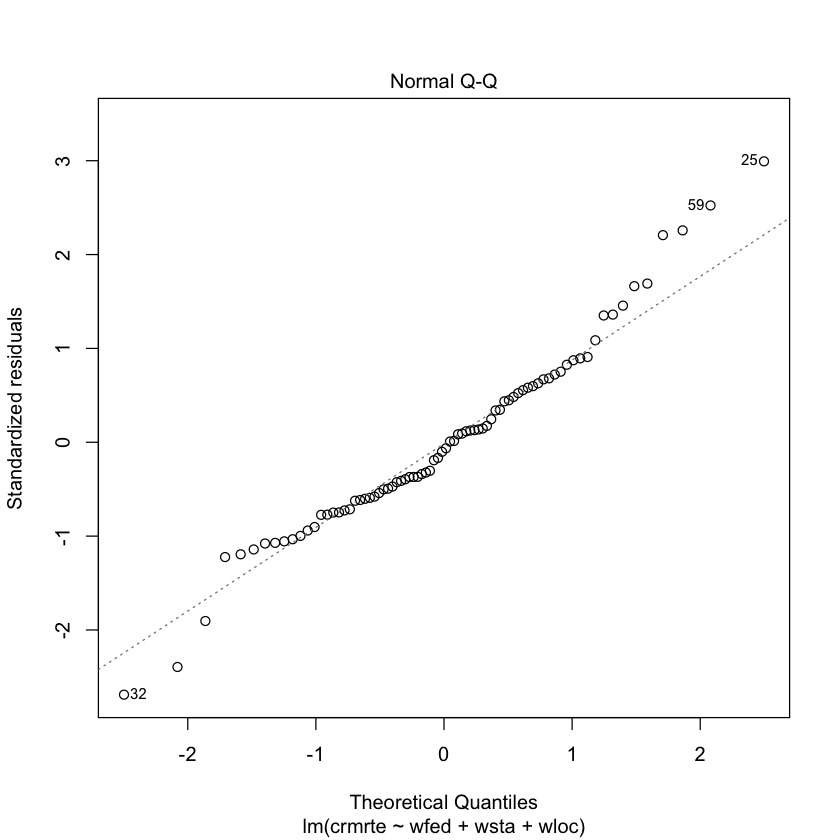

In [77]:
plot(model, which = 2)

After accounting for heteroskedasticity using robust standard errors, we see that `wfed` is our significicant variable. In particular, it seems that every 1% increase in federal wages seems to correlate with a 1.4% increase in crime rate. However, as we will discuss below, this counterintuitive result is likely due to latent variables.

In [84]:
summary(model)


Call:
lm(formula = crmrte ~ wfed + wsta + wloc, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1089 -0.2597 -0.0354  0.2450  1.2293 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.5176     3.6298  -5.653 2.63e-07 ***
wfed          1.3981     0.4056   3.447 0.000928 ***
wsta          0.2121     0.4205   0.504 0.615426    
wloc          1.2711     0.6329   2.008 0.048159 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4321 on 76 degrees of freedom
Multiple R-squared:  0.3033,	Adjusted R-squared:  0.2758 
F-statistic: 11.03 on 3 and 76 DF,  p-value: 4.318e-06


In [87]:
coeftest(model, vcov = vcovHC)


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -20.51759    4.00493 -5.1231 2.213e-06 ***
wfed          1.39805    0.62840  2.2248   0.02906 *  
wsta          0.21211    0.34085  0.6223   0.53561    
wloc          1.27110    0.91156  1.3944   0.16726    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Some of the major omitted variables that we believe could have a significant impact on crime rates include the population density and the police presence within an area. 

As seen in the scatter plot below, population density is most likely positively correlated with both crime rate as well as wages (as wages tend to be higher in cities, which have higher population densities); we also see this in the calculated correlation. Because the omitted population density variable is positively correlated with both our endogenous and included exogenous variables, it is likely artificially increasing the modeled effect of the included exogenous variables. Said another way, because positive effect of population density on crime is not included, it is partially included in the wage variables, causing the coefficients/effect of the wage variables on crime to be more positive than they may be in reality.

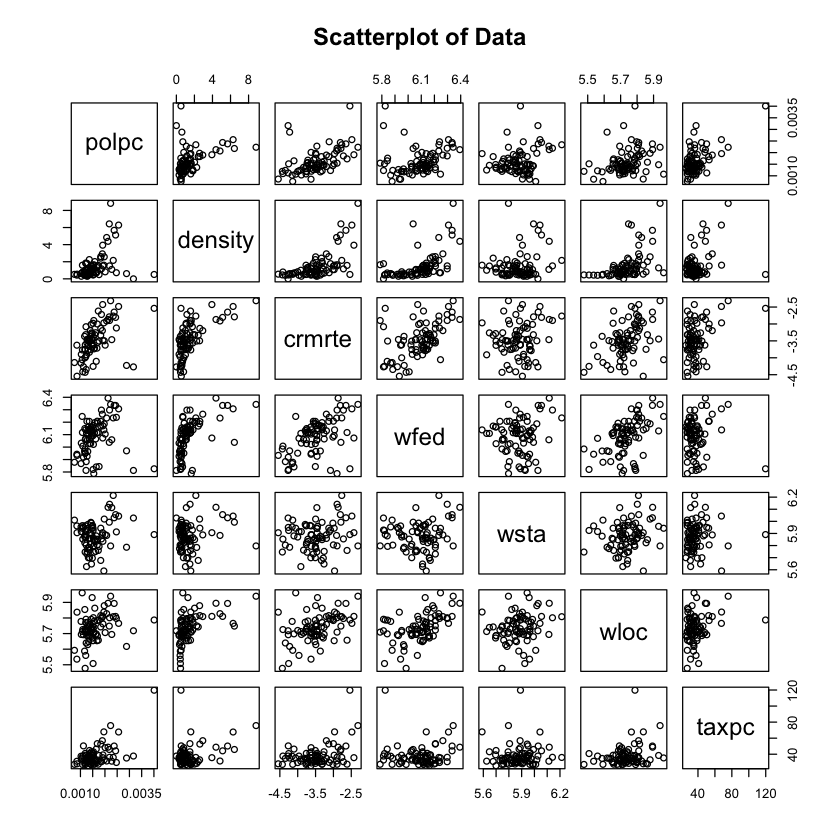

In [91]:
pairs(~polpc + density + crmrte + wfed + wsta + wloc + taxpc,data=data,
   main="Scatterplot of Data")

`wtrd`, the wage of the retail industry, has the largest coefficient of 0.0001155, indicating that every \$1000 increase in weekly retail wages could be associated with an 0.12 increase in average crimes per person. On the other hand, `wfir`, the weekly wage of the finance / insurance / real estate industries, has the most negative coefficient of -0.0000642, indicating that every \$1000 increase in weekly finance / insurance / real estate wages could be associated with a 0.06 decrease in average crimes per person. However, rather than jumping to conclusions on the effect of wages to crime, we realize that this initial baseline model has many different omitted latent variables that could be affecting the results of our analysis. 

There are a number of variables omitted from our first model that may have a big effect, including:
* GDP (per-capita growth)
* Drug use and addiction
* Strength of education system (pct with college degrees)
* Strength of education system (special ed)
* Strength of education system (K-12)
* Households with single parent
* Housing prices
* Employment rate
* Religion (pct people identifying as religious/spiritual)
* Physical environment (natural disasters rate / temperature / weather)
* Government funding for social welfare
* Population growth
* Job growth
* Cost of living

In order to control for some of the effects of the omitted variables, we next create a second model with our model-1 coefficients in addition to:
* `taxpc`
* `polpc`
* `density`
* `pctymle`
* `prbarr`

Therefore: `Model 2 = Model 1 + taxpc, density, pctymle, polpc, prbarr`

# Model 2

In our second model, we are looking for non-wage variables that may be able to explain as much of the variation in crime rate as possible so that we can focus on the incremental effect of wage variables.

Thus, while we have decided to transform our dependent variable or the wage related variables for explainability, we're comfortable transforming any of the other variables in any way that can lead to a better fit for our model.

We create a correlation matrix of our non-wage variables (linear and transformed) with crime rate to help us assess whether to use the original linear variables in our subsequent models or to use the corresponding transformed variables. For each non-wage variable, we'll choose the transformation that has the highest correlation with crime rate.

In [33]:
linear = cor(data.frame(data, data$crmrte))[,25]
logarithm = cor(data.frame(log(data), data$crmrte))[,25]
square_root = cor(data.frame(sqrt(data), data$crmrte))[,25]
square = cor(data.frame(data^2, data$crmrte))[,25]

df1 = data.frame(linear, logarithm, square_root, square)
df1[c(3:13, 23:24),]

,linear,logarithm,square_root,square
prbarr,-0.407623882,-0.43603457,-0.42891421,-0.33018870
prbconv,-0.384734631,-0.30796639,-0.35764853,-0.40294654
prbpris,0.052840613,0.09037005,0.07152836,0.01825894
avgsen,0.007397583,0.05419136,0.03161315,-0.04259903
polpc,0.164891574,0.38662275,0.28644420,-0.03142815
density,0.727522933,0.47403654,0.73040522,0.66086033
taxpc,0.457646315,0.42502877,0.44568208,0.44584684
west,-0.360758914,NaN,-0.36075891,-0.36075891
central,0.190233555,NaN,0.19023356,0.19023356
urban,0.616765513,NaN,0.61676551,0.61676551


A scatterplot matrix of crime rate with the non-wage variables before and after transformations shows that the transformed variables both seem to be more normally distributed and have a more linear relationship with crime rate.

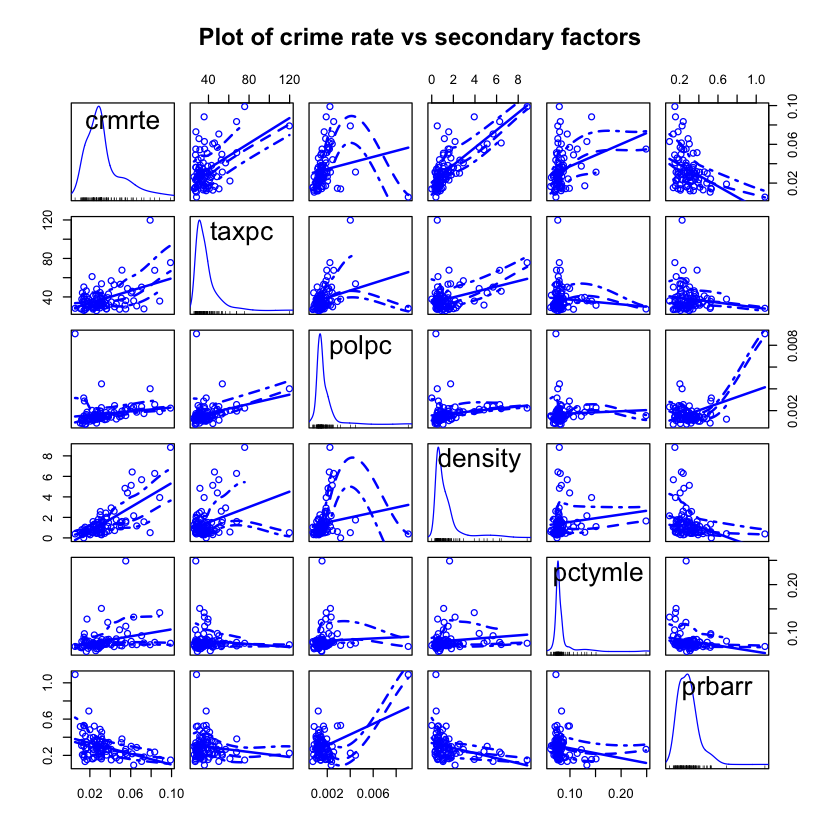

In [34]:
library(car)
scatterplotMatrix(~crmrte + taxpc + polpc + density + pctymle + prbarr, data=data,
                   main="Plot of crime rate vs secondary factors")

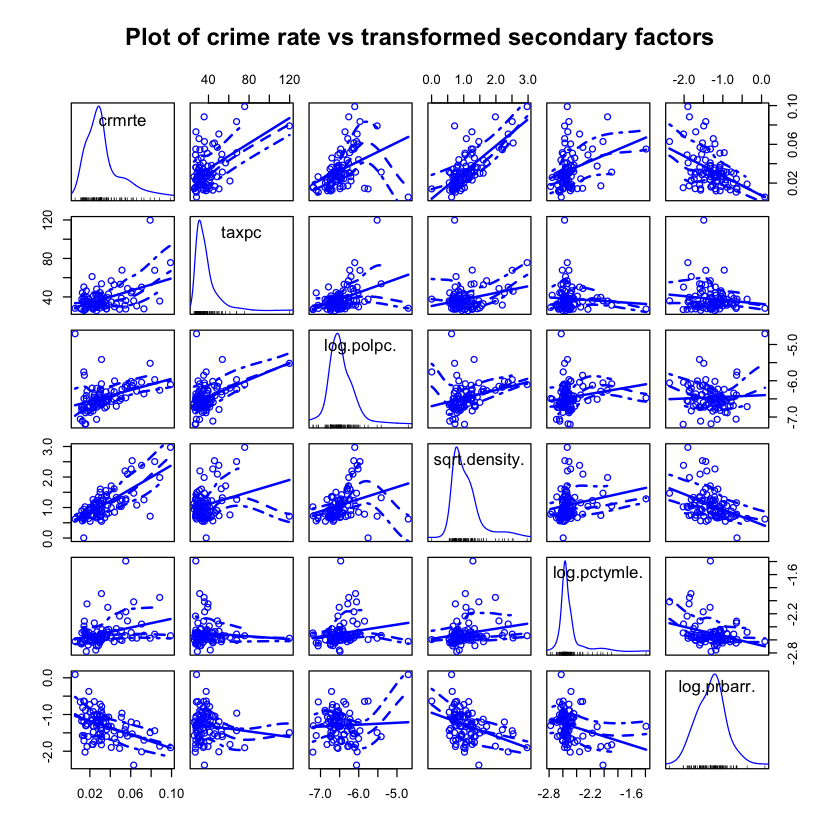

In [35]:
scatterplotMatrix(~crmrte + taxpc + log(polpc) + sqrt(density) + log(pctymle) + log(prbarr) , data=data,
                   main="Plot of crime rate vs transformed secondary factors")

We revise the definition of our 2nd model as follows:

`Model 2 = Model 1 + taxpc, sqrt(density), log(pctymle), log(polpc), log(prbarr)`

------------------------------------------------


First we will start out by creating a model where every variable is untransformed.

In [36]:
secondary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
                     wfed + wsta + wloc + taxpc + density + pctymle + 
                     polpc + prbarr, data=data)
secondary_model_summary = summary(secondary_model)
c('Adjusted R-Squared is', secondary_model_summary$adj.r.squared)
secondary_model_summary

[1] "Adjusted R-Squared is" "0.693138321505037"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + density + pctymle + polpc + 
    prbarr, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.024724 -0.004991 -0.000171  0.005016  0.033769 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.318e-02  2.003e-02  -1.157  0.25080    
wcon         1.540e-05  3.313e-05   0.465  0.64343    
wtuc        -5.951e-07  1.759e-05  -0.034  0.97311    
wtrd         4.091e-05  5.540e-05   0.739  0.46247    
wfir        -5.561e-05  3.267e-05  -1.702  0.09286 .  
wser        -1.203e-04  3.903e-05  -3.083  0.00287 ** 
wmfg        -1.402e-06  1.702e-05  -0.082  0.93458    
wfed         9.740e-05  3.045e-05   3.198  0.00202 ** 
wsta        -1.879e-06  2.998e-05  -0.063  0.95020    
wloc         4.073e-05  5.975e-05   0.682  0.49756    
taxpc        4.414e-04  1.044e-04   4.226 6.63e-05 ***
density      6.105e-03  1.084e-03   5.632 2.95e-07 *

We then apply the best correlations from the correlation table and adjust the secondary variables.

In [37]:
secondary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + 
                     wmfg + wfed + wsta + wloc + taxpc + sqrt(density) + 
                     log(pctymle) + log(polpc) + log(prbarr), data=data)
secondary_model_summary = summary(secondary_model)
c('Adjusted R-Squared is', secondary_model_summary$adj.r.squared)
secondary_model_summary

[1] "Adjusted R-Squared is" "0.696623968204726"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + sqrt(density) + log(pctymle) + 
    log(polpc) + log(prbarr), data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0239501 -0.0052841  0.0004469  0.0050843  0.0293214 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.004e-02  3.544e-02   1.976  0.05181 .  
wcon           2.393e-05  3.246e-05   0.737  0.46340    
wtuc          -4.557e-06  1.749e-05  -0.261  0.79514    
wtrd           5.604e-05  5.487e-05   1.021  0.31045    
wfir          -5.474e-05  3.242e-05  -1.688  0.09548 .  
wser          -1.310e-04  3.898e-05  -3.360  0.00123 ** 
wmfg          -3.629e-06  1.692e-05  -0.214  0.83079    
wfed           7.140e-05  3.151e-05   2.266  0.02636 *  
wsta          -1.233e-08  3.004e-05   0.000  0.99967    
wloc           2.151e-05  5.703e-05   0.377  0.70715    
taxpc          4.572e-04  1.060e-04   4.313 4.85e-05 *

After adding secondary (transformed & non transformed) variables, we do see that the overall impact of wage-related economic variables has gone down. We see that the variables most correlated with crime rates are now `pctymle`, `log(polpc)` and `log(prbarr)`. The square root of `pctymle` is highly correlated to crime rate with a p-value of 0.00162, indicating that an increase in `pctymle` leads to an increase in crime rate.

# Model 3

Lastly, we will turn to the following remaining variables to create a final model with additional features that we believe might affect crime rate, even if we believe the effect may be minimal: 
* `pctmin80`
* `prbconv`
* `prbpris`
* `avgsen`
* `west`
* `central`

Our final model is: 
`Model 3 = Model 2 + pctmin80, prbconv, prbpris, avgsen, west, central`

In [38]:
tertiary_model = lm(crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + wfed + wsta + wloc 
                    + taxpc + sqrt(density) + sqrt(pctymle) + log(polpc) + log(prbarr) + log(pctmin80) +
                    log(prbpris) + prbconv^2 + log(avgsen) + west + central , data=data)
tertiary_model_summary = summary(tertiary_model)
paste('Adjusted R-Squared is', tertiary_model_summary$adj.r.squared)
tertiary_model_summary

[1] "Adjusted R-Squared is 0.804983761963971"


Call:
lm(formula = crmrte ~ wcon + wtuc + wtrd + wfir + wser + wmfg + 
    wfed + wsta + wloc + taxpc + sqrt(density) + sqrt(pctymle) + 
    log(polpc) + log(prbarr) + log(pctmin80) + log(prbpris) + 
    prbconv^2 + log(avgsen) + west + central, data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0203658 -0.0044360  0.0000262  0.0036173  0.0219305 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.390e-02  3.745e-02   1.172 0.245128    
wcon           3.120e-05  2.723e-05   1.146 0.255917    
wtuc           1.479e-05  1.502e-05   0.984 0.328407    
wtrd           4.374e-05  4.549e-05   0.962 0.339596    
wfir          -3.087e-05  2.708e-05  -1.140 0.258225    
wser          -1.163e-04  3.246e-05  -3.581 0.000632 ***
wmfg           2.243e-06  1.378e-05   0.163 0.871206    
wfed           4.331e-05  2.683e-05   1.614 0.111021    
wsta          -1.367e-06  2.484e-05  -0.055 0.956260    
wloc           3.589e-05  4.708

By including additional explanatory variables, we see that most of our wage variables now have only a negigible effect, with the majority of the variation described by taxpc, density, pctmle, polpc, prbarr, pctmin80, prbconv, avgsen, and central.

Interesting, we do notice that `wser` seems to have a significant, though small, negative effect on crime rate. In particular, every \$1000 increase in average wages in the services industry reduces crime by 0.12 crimes per person. 

# Conclusion and recommendations

Given our various model runs and correlation analyses of `crmrte` with respect to various transformed and non-transformed variables, and in light of our initial research question ("whether economic prosperity helps in reducing crime?"), we cannot formally conclude that wage-related economic determinants are helpful in reducing crime in North Carolina. `wser` (wages in the services sector) seems to be the only exception in the wage-variables with a very low p-value of 0.00166, indicating high significance of its coefficient. However, the small value of its beta leads us to believe that the overall impact of `wser` on `crmrte` is still miniscule compared to other secondary and tertiary variables.

We do see, however, that metrics such as `taxpc`, `polpc`, `density` have low p-values and high correlation components with `crmrte`. We do not state that these variables have a causal impact on crime statistics in the state -- and believe that `crmrte` could also be possibly correlated with latent variables outlined in our text above. 

In [53]:
stargazer(model, secondary_model, tertiary_model, type = "text", 
          digits=5, omit.stat = c("f","ser"))


                      Dependent variable:        
              -----------------------------------
                            crmrte               
                  (1)         (2)         (3)    
-------------------------------------------------
wcon            0.00007     0.00002     0.00003  
               (0.00005)   (0.00003)   (0.00003) 
                                                 
wtuc           -0.000003   -0.000005    0.00001  
               (0.00003)   (0.00002)   (0.00002) 
                                                 
wtrd            0.00012     0.00006     0.00004  
               (0.00008)   (0.00005)   (0.00005) 
                                                 
wfir           -0.00006    -0.00005*   -0.00003  
               (0.00005)   (0.00003)   (0.00003) 
                                                 
wser           -0.00001   -0.00013*** -0.00012***
               (0.00006)   (0.00004)   (0.00003) 
                                                 

### Policy recommendations

Originally we were exploring the idea that whether wages in the North Carolina congressional districts were related to crime statistics in the state. We were hoping to find a possible statistical significance of wages on crime rates, through which we could implement some economic or social sector programs related to jobs and labor growth and/or raising minimum wages in the state.

However, because we could not find the statistical significance of wages on crime rate; and instead have found other factors such as density, percentage young males and probability of arrest as having more correlation with crime rates, we are proposing the following set of recommendations: 
- Encourage a rejuvenation of suburban and exurban areas around bigger cities to promote the decrease urban congestion and thereby reduce population density of the area
- Institute statewide police training programs so the officers are better in apprehending criminals (possibly by increasing funding of police force and not necessarily by increasing the number of police officers -- given that `polpc` variable is not correlated to crime rate
